**The Brave Ducks**

**Checkpoint 5: Natural Language Processing**

**Overview:** With the following exploration of the Chicago Polic Database, we inspect further in the overall sentiment with regards to police misconduct in low, middle and high income neighborhoods. The exploration of the following questions is done via NLP, conducted using Tokenization, Transformer and Sentiment Analysis tools, processed in the attached Google Colab notebook.

**Questions we seek to answer with NLP:**
1.   What are the top 15 most frequent words in the narrative context in the low, middle, high income neighborhoods?
2.    What are the most frequently used words by an accuser? What are the most frequently used words by an accused officer? We will be answering these questions with regards to socialeconomic status and police misconduct (i.e. illegal search, use of force).
3.   What misconduct was alleged by the accuser? We want to understand what the officer is being accused of and we want to figure out what the socialeconomic status is of the accuser. This will give us insight into if the accuser behaves differently depending on their socialeconomic status.
4.   What are the top 5 negative complaint narratives for each income neighborhoods?



In [ ]:
!pip install transformers datasets torch numpy pandas wordninja

     |████████████████████████████████| 3.1 MB 4.3 MB/s 
     |████████████████████████████████| 298 kB 45.5 MB/s 
     |████████████████████████████████| 541 kB 44.8 MB/s 
     |████████████████████████████████| 596 kB 45.8 MB/s 
     |████████████████████████████████| 895 kB 37.6 MB/s 
     |████████████████████████████████| 3.3 MB 36.6 MB/s 
     |████████████████████████████████| 59 kB 6.8 MB/s 
     |████████████████████████████████| 1.1 MB 49.3 MB/s 
     |████████████████████████████████| 243 kB 45.7 MB/s 
     |████████████████████████████████| 132 kB 53.0 MB/s 
     |████████████████████████████████| 271 kB 53.4 MB/s 
     |████████████████████████████████| 160 kB 36.5 MB/s 
     |████████████████████████████████| 192 kB 50.6 MB/s 
  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541551 sha256=57d089e1e6ccb77f025bdb3349116a1705a61517d58cb479699e95fb879d9911
  Stored in directory: /root/.cache/pip/wheels/dd/3f/eb/a2692e3d2b9deb1487b09ba4967dd6920bd5

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from transformers import pipeline
from transformers import BertTokenizer
from collections import Counter
from spacy.tokens import Token
from spacy.matcher import Matcher
from spacy.strings import StringStore
from copy import deepcopy
import spacy
import torch
import re
import wordninja
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tokenize = spacy.load('en_core_web_sm')

In [ ]:
query = pipeline('question-answering', device=0)
sentiment_analyzer = pipeline('sentiment-analysis', device=0)
zero_shot_classifier = pipeline('zero-shot-classification', device=0)

No model was supplied, defaulted to distilbert-base-cased-distilled-squad (https://huggingface.co/distilbert-base-cased-distilled-squad)


Downloading:   0%|          | 0.00/473 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/249M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

No model was supplied, defaulted to facebook/bart-large-mnli (https://huggingface.co/facebook/bart-large-mnli)


Downloading:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

# Text Normalization and Cleaning

## Reading Dataframe from a narrative CSV

## Please upload all CSV files from the project folder to google Collab included in the zip file!

In [ ]:
narratives = pd.read_csv('narratives.csv',
                         usecols=['cr_id', 'column_name', 'text'],
                         dtype={"cr_id": "string", "column_name": "string", "text": "string"})

initial = narratives.shape[0]
narratives

,cr_id,column_name,text
0,1050727,Initial / Intake Allegation,It is alleged that the accused officer failed ...
1,1050727,Finding,(None Entered)
2,1050727,Allegation,It is alleged by the complainant Sergeant Vict...
3,1050727,Initial / Intake Allegation,It is alleged that the accused officer failed ...
4,1050814,Initial / Intake Allegation,‘The reporting party alleges that he left a le...
...,...,...,...
45471,1073835,Initial / Intake Allegation,THE REPORTING PARTY ALLEGES THAT THE ACCUSED O...
45472,1073835,Finding,(None Entered)
45473,1073835,Initial / Intake Allegation,THE REPORTING PARTY ALLEGES THAT THE ACCUSED O...
45474,1073894,Initial / Intake Allegation,"that the subject U.S.C., cellular phone, WAS T..."


## Data Cleaning by removing "invalid" rows

In [ ]:
def clean(text):
  if text in ['(None Entered)', 'NO AFFIDAVIT']: return ''

  text = text.replace('\n', ' ').replace('|', 'I').strip()

  text = ' '.join([word for token in text.split() for word in (wordninja.split(token) if token.isalpha() else [token])])
  return text


print(narratives.loc[3664, :]['text'].__repr__())
narratives['text'] = narratives.loc[:,'text'].map(clean)
narratives = narratives[narratives['text'] != '']
print(f'{initial - narratives.shape[0]} entries removed')
print(narratives.loc[3664, :]['text'])
narratives

'The reporting party alleges that the\naccused officer was rude and\nunprofessional during a traffic stop, the\naccused officer threatened to place her in\nhandcuffs and failed to inform the\ncomplainant as to why she was being\nstopped.\nThe reporting party further alleges that the\nofficer stated,"License and registration now\nbefore | snatch you out of this car and put\nyou in handcuffs."'
13486 entries removed
The reporting party alleges that the accused officer was rude and unprofessional during a traffic stop, the accused officer threatened to place her in handcuffs and failed to in form the complainant as to why she was being stopped. The reporting party further alleges that the officer stated,"License and registration now before I snatch you out of this car and put you in handcuffs."


,cr_id,column_name,text
0,1050727,Initial / Intake Allegation,It is alleged that the accused officer failed ...
2,1050727,Allegation,It is alleged by the complainant Sergeant Vict...
3,1050727,Initial / Intake Allegation,It is alleged that the accused officer failed ...
4,1050814,Initial / Intake Allegation,‘The reporting party alleges that he left a le...
6,1050814,Initial / Intake Allegation,The reporting party alleges that he left a lea...
...,...,...,...
45470,1073828,Initial / Intake Allegation,The reporting party alleged that no officer pr...
45471,1073835,Initial / Intake Allegation,THE REPORTING PARTY ALLEGES THAT THE ACCUSED O...
45473,1073835,Initial / Intake Allegation,THE REPORTING PARTY ALLEGES THAT THE ACCUSED O...
45474,1073894,Initial / Intake Allegation,"that the subject U.S.C., cellular phone, WAS T..."


## Data cleaing by removing all duplicates

In [ ]:
narratives = narratives.sort_values('text', ascending=False)\
                       .drop_duplicates('cr_id')\
                       .sort_values('cr_id')

print(f'{initial - narratives.shape[0]} entries removed')
narratives

30509 entries removed


,cr_id,column_name,text
3664,1048960,Initial / Intake Allegation,The reporting party alleges that the accused o...
3667,1048962,Finding,UNFOUNDED
3673,1048964,Initial / Intake Allegation,The reporting party alleges that he was a vict...
3676,1048965,Initial / Intake Allegation,The reporting party alleges that while waiting...
3679,1048966,Initial / Intake Allegation,The Reporting Party Victim stated that she tel...
...,...,...,...
18781,1076168,Initial / Intake Allegation,The complainant related the accused officer ar...
18786,1076169,Initial / Intake Allegation,THE REPORTING PARTY STATES THAT 2-3 YEARS AGO ...
18789,1076174,Initial / Intake Allegation,The reporting victim alleged the accused pushe...
18792,1076176,Initial / Intake Allegation,The reporting party victim alleges that the ac...


## Creating a joined table with social-economic statuses of complainants for each police allegation (race, gender, income neighborhoods)

In [ ]:
# Creating a joined table with race and gender of complainants for each allegation
print(len(narratives))
complainants = pd.read_csv('Complainants.csv',
                         usecols=['crid', 'race', 'gender', 'neighborhood_income_level'],
                         dtype={"crid": "string", "race": "string", "gender": "string", "neighborhood_income_level": "string"})

complainants = complainants[['crid', 'race', 'gender', 'neighborhood_income_level']].drop_duplicates('crid')
complainants.columns = ['cr_id', 'race', 'gender', 'neighborhood_income_level']
narratives = narratives.merge(complainants, how='left')


14967


## Separate narratives into low, middle, high income neighborhoods for further investigations

In [ ]:
lowIncomeNarratives = deepcopy(narratives)
lowIncomeNarratives = lowIncomeNarratives[lowIncomeNarratives['neighborhood_income_level'] == 'Low']

middleIncomeNarratives = deepcopy(narratives)
middleIncomeNarratives = middleIncomeNarratives[middleIncomeNarratives['neighborhood_income_level'] == 'Middle']

highIncomeNarratives = deepcopy(narratives)
highIncomeNarratives = highIncomeNarratives[highIncomeNarratives['neighborhood_income_level'] == 'High']

# Tokenization with parsing rules

**Overview: Tokenization is essentially splitting a phrase, sentence, paragraph, or an entire text document into smaller units, such as individual words or terms. We want to first investigate what are the top 15 frequent word in different income neighborhoods**

**Question 1: What are the top 15 most frequent words in the narrative context in the low, middle, high income neighborhoods?**


In [ ]:
lowCounts = Counter([word.lower() for narrative in lowIncomeNarratives['text'] for word in narrative.split()])
print(len(lowCounts))
print(lowCounts.most_common(15))

1870
[('the', 1163), ('that', 493), ('and', 371), ('accused', 334), ('to', 322), ('reporting', 280), ('party', 259), ('alleges', 225), ('a', 208), ('officer', 193), ('his', 192), ('him', 171), ('alleged', 167), ('her', 151), ('of', 132)]


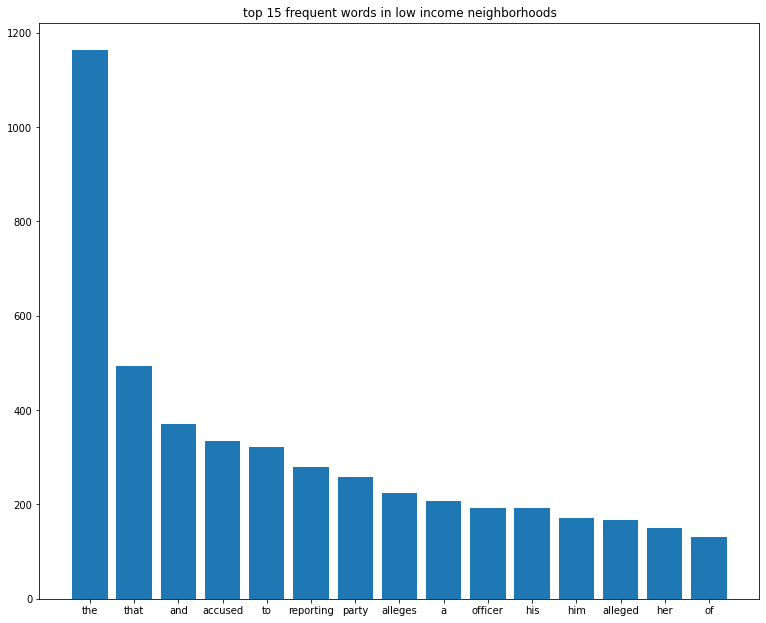

In [ ]:
graph = list(lowCounts.most_common(15))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
words = [word for word, freq in graph]
freqs = [freq for word, freq in graph]
ax.bar(words, freqs)
fig.set_size_inches(10, 8)
plt.title("top 15 frequent words in low income neighborhoods")
plt.show()


In [ ]:
middleCounts = Counter([word.lower() for narrative in middleIncomeNarratives['text'] for word in narrative.split()])
print(len(middleCounts))
print(middleCounts.most_common(15))

3233
[('the', 2607), ('that', 1126), ('and', 781), ('to', 774), ('accused', 723), ('a', 548), ('reporting', 545), ('party', 504), ('alleges', 497), ('her', 458), ('his', 377), ('was', 353), ('officer', 347), ('him', 332), ('he', 330)]


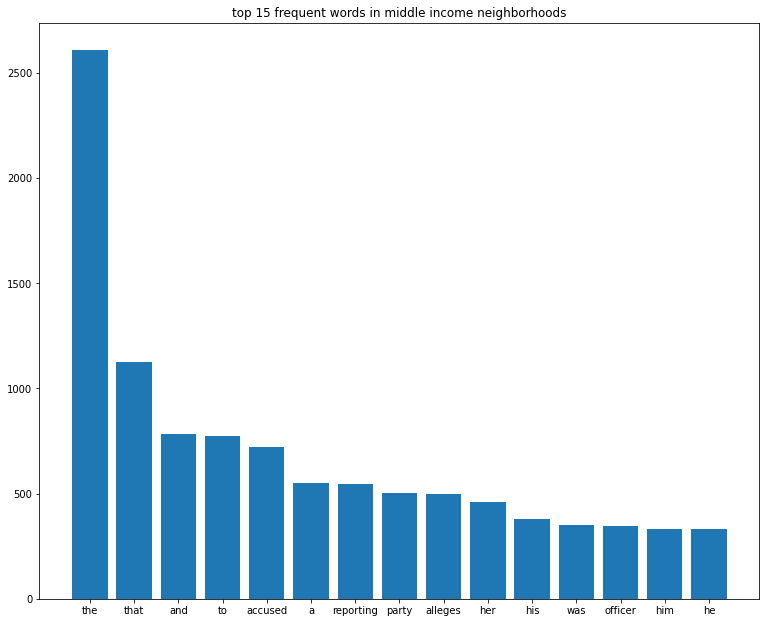

In [ ]:
graph = list(middleCounts.most_common(15))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
words = [word for word, freq in graph]
freqs = [freq for word, freq in graph]
ax.bar(words, freqs)
fig.set_size_inches(10, 8)
plt.title("top 15 frequent words in middle income neighborhoods")
plt.show()


In [ ]:
highCounts = Counter([word.lower() for narrative in highIncomeNarratives['text'] for word in narrative.split()])
print(len(highCounts))
print(highCounts.most_common(15))

11021
[('the', 17856), ('that', 7674), ('to', 5628), ('and', 5402), ('accused', 5053), ('a', 3764), ('reporting', 3744), ('party', 3400), ('alleges', 3216), ('her', 2810), ('officer', 2675), ('his', 2640), ('was', 2287), ('alleged', 2256), ('him', 2231)]


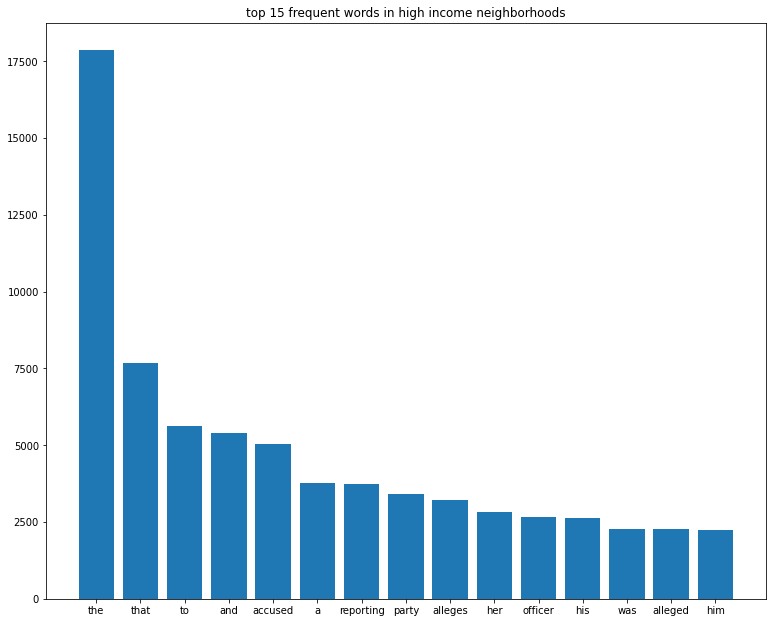

In [ ]:
graph = list(highCounts.most_common(15))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
words = [word for word, freq in graph]
freqs = [freq for word, freq in graph]
ax.bar(words, freqs)
fig.set_size_inches(10, 8)
plt.title("top 15 frequent words in high income neighborhoods")
plt.show()


The print statement and the graph above shows the top 15 most frequent words in the narrative context in the low, middle, high income neighborhoods. Some of the interesting thing that we find is that in low income neighborhoods officer is spoken much more frequently than the two other income neighborhoods. However, this analysis is very rudimentary since it takes into many ordinary words, such as "the", "that", etc. We would like to investigate more into this by relating to our theme of investigating police misconduct in different neighborhoods via spacy tokenization.

## Tokenization with spacy

Overview: In Spacy, the process of tokenizing a text into segments of words and punctuation is done in various steps. It processes the text from left to right.

First, the tokenizer split the text on whitespace similar to the split() function.
Then the tokenizer checks whether the substring matches the tokenizer exception rules. For example, “don’t” does not contain whitespace, but should be split into two tokens, “do” and “n’t”, while “U.K.” should always remain one token.
Next, it checks for a prefix, suffix, or infix in a substring, these include commas, periods, hyphens, or quotes. If it matches, the substring is split into two tokens.

In [ ]:
tokens = tokenize(narratives.loc[0, 'text'])
[t for t in tokens]

[The,
 reporting,
 party,
 alleges,
 that,
 the,
 accused,
 officer,
 was,
 rude,
 and,
 unprofessional,
 during,
 a,
 traffic,
 stop,
 ,,
 the,
 accused,
 officer,
 threatened,
 to,
 place,
 her,
 in,
 handcuffs,
 and,
 failed,
 to,
 in,
 form,
 the,
 complainant,
 as,
 to,
 why,
 she,
 was,
 being,
 stopped,
 .,
 The,
 reporting,
 party,
 further,
 alleges,
 that,
 the,
 officer,
 stated,"License,
 and,
 registration,
 now,
 before,
 I,
 snatch,
 you,
 out,
 of,
 this,
 car,
 and,
 put,
 you,
 in,
 handcuffs,
 .,
 "]

## Use special tokens for police misconduct ('misconduct', 'force', 'illegal', 'search', 'use', 'drug', 'offenders', 'warrant', 'permissions')

In [ ]:

keywords = ['misconduct', 'force', 'illegal', 'search', 'use', 'drug', 'offenders', 'warrant', 'permissions']
Token.set_extension('important', getter=lambda t: t.lemma_ in keywords, force=True)
tokens = tokenize(narratives.loc[0, 'text'])

## Parsing with these special tokens as rule

In [ ]:
patterns = [
            [{'POS': 'NOUN'}, {'_': {'important': True}}],
            [{'_': {'important': True}}, {'POS': 'NOUN'}]
            ]


matcher = Matcher(tokenize.vocab, validate=True)
matcher.add('Accuser', [patterns[0]])
matcher.add('Accused', [patterns[1]])
matches = matcher(tokens)

for match_id, start, end in matches:
  string = tokenize.vocab.strings[match_id]
  span = tokens[start:end]
  print(f'{string}: \'{span}\'')

In [ ]:
def get_matches(narrative):
  tokens = tokenize(narrative)
  matches = matcher(tokens)

  accusers, accused = [], []

  for match_id, start, end in matches:
    string = tokenize.vocab.strings[match_id]
    span = tokens[start:end]
    if string == 'Accuser':
      accusers.append(span[0].text)
    else:
      accused.append(span[1].text)

  return accusers, accused


**Queston 2. What are the most frequently used words by an accuser? What are the most frequently used words by an accused officer? We will be answering these questions with regards to socialeconomic status and police misconduct (i.e. illegal search, use of force).**

In [ ]:
accusers_accused = lowIncomeNarratives['text'].map(get_matches)
lowIncomeNarratives['accuser'] = accusers_accused.map(lambda l: l[0])
lowIncomeNarratives['accused'] = accusers_accused.map(lambda l: l[1])


results = {
    'Accusers': Counter([accuser for accusers in lowIncomeNarratives['accuser'] for accuser in accusers]).most_common(),
    'Accused': Counter([accused for accuseds in lowIncomeNarratives['accused'] for accused in accuseds]).most_common()
}

for k,v in results.items():
  print(f'{k}: {v[:10]}')

Accusers: [('officer', 10), ('officers', 3), ('OFFICERS', 1), ('ccc', 1), ('offenders', 1), ('tef', 1), ('search', 1)]
Accused: [('activity', 4), ('dealers', 2), ('paraphernalia', 2), ('drug', 1), ('officers', 1), ('narcotics', 1), ('possession', 1), ('profanity', 1), ('dumping', 1), ('profane', 1)]


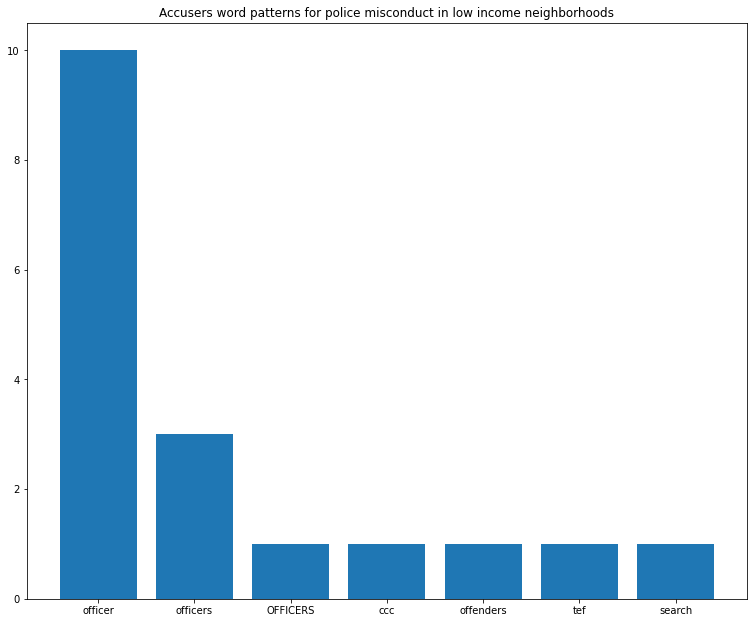

In [ ]:
graph = results['Accusers']
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
words = [word for word, freq in graph]
freqs = [freq for word, freq in graph]
ax.bar(words, freqs)
fig.set_size_inches(10, 8)
plt.title("Accusers word patterns for police misconduct in low income neighborhoods")
plt.show()

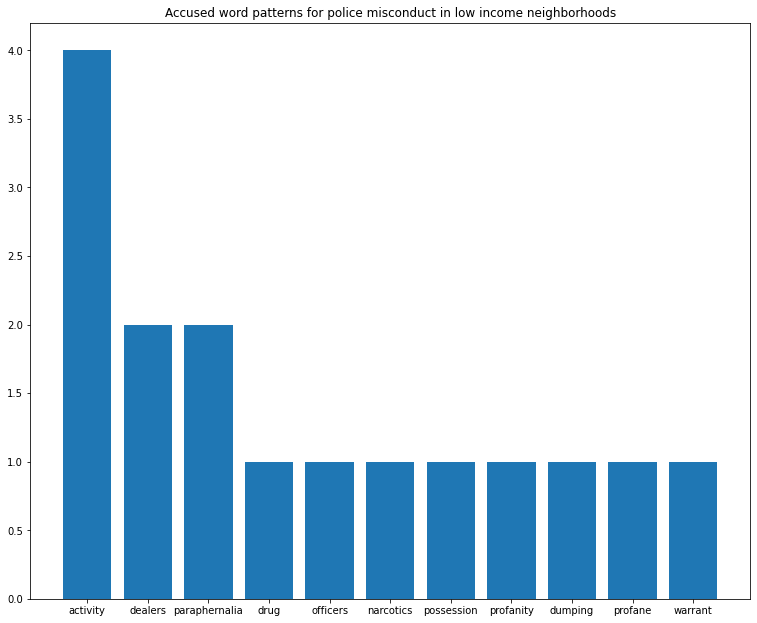

In [ ]:
graph = results['Accused']
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
words = [word for word, freq in graph]
freqs = [freq for word, freq in graph]
ax.bar(words, freqs)
fig.set_size_inches(10, 8)
plt.title("Accused word patterns for police misconduct in low income neighborhoods")
plt.show()

In [ ]:
accusers_accused = middleIncomeNarratives['text'].map(get_matches)
middleIncomeNarratives['accuser'] = accusers_accused.map(lambda l: l[0])
middleIncomeNarratives['accused'] = accusers_accused.map(lambda l: l[1])
results = {
    'Accusers': Counter([accuser for accusers in middleIncomeNarratives['accuser'] for accuser in accusers]).most_common(),
    'Accused': Counter([accused for accuseds in middleIncomeNarratives['accused'] for accused in accuseds]).most_common()
}

for k,v in results.items():
  print(f'{k}: {v[:10]}')

Accusers: [('officer', 16), ('officers', 11), ('search', 9), ('INAPPROPRIATELY', 2), ('RS', 1), ('ers', 1), ('tef', 1), ('cavity', 1), ('people', 1)]
Accused: [('warrant', 9), ('test', 2), ('drugs', 2), ('DEALER', 2), ('charges', 1), ('court', 1), ('dealer', 1), ('victim', 1), ('cavity', 1)]


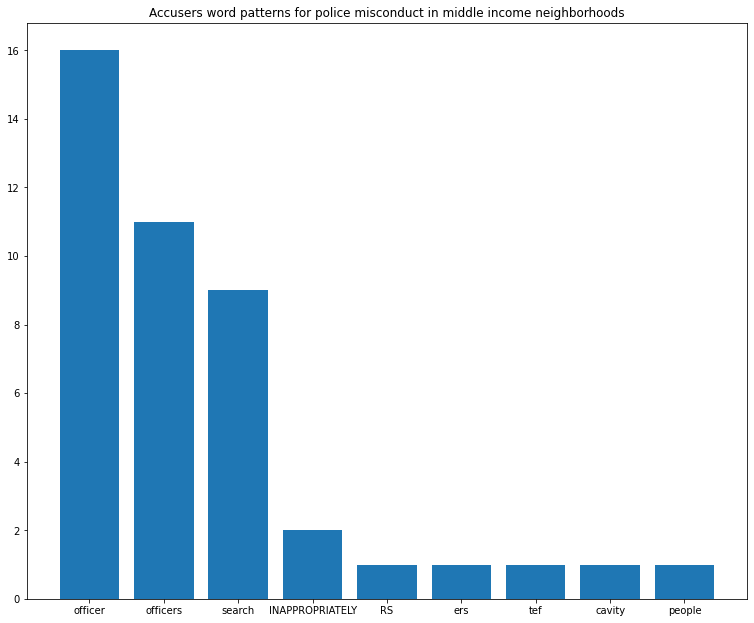

In [ ]:
graph = results['Accusers']
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
words = [word for word, freq in graph]
freqs = [freq for word, freq in graph]
ax.bar(words, freqs)
fig.set_size_inches(10, 8)
plt.title("Accusers word patterns for police misconduct in middle income neighborhoods")
plt.show()

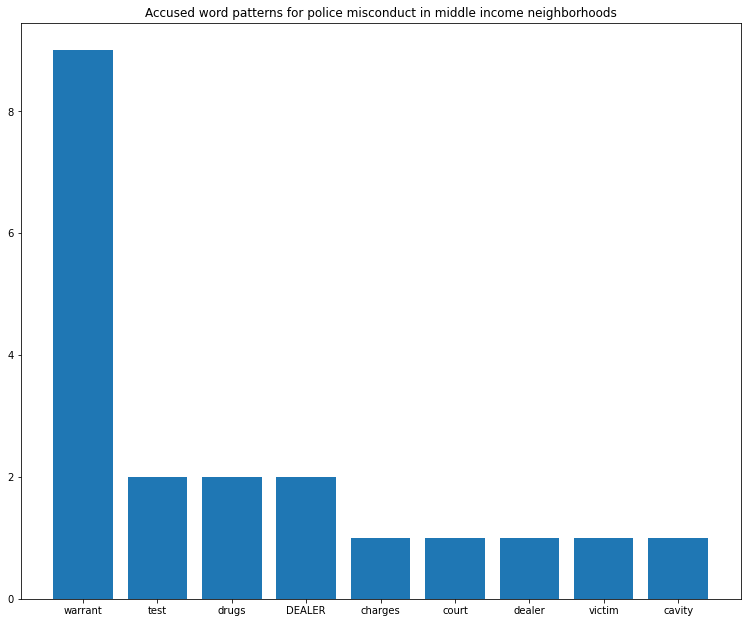

In [ ]:
graph = results['Accused']
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
words = [word for word, freq in graph]
freqs = [freq for word, freq in graph]
ax.bar(words, freqs)
fig.set_size_inches(10, 8)
plt.title("Accused word patterns for police misconduct in middle income neighborhoods")
plt.show()

In [ ]:
accusers_accused = highIncomeNarratives['text'].map(get_matches)
highIncomeNarratives['accuser'] = accusers_accused.map(lambda l: l[0])
highIncomeNarratives['accused'] = accusers_accused.map(lambda l: l[1])


results = {
    'Accusers': Counter([accuser for accusers in highIncomeNarratives['accuser'] for accuser in accusers]).most_common(),
    'Accused': Counter([accused for accuseds in highIncomeNarratives['accused'] for accused in accuseds]).most_common()
}

for k,v in results.items():
  print(f'{k}: {v[:10]}')

Accusers: [('officer', 79), ('officers', 48), ('tef', 13), ('INAPPROPRIATELY', 9), ('ccc', 5), ('cavity', 5), ('OFFICER', 4), ('co', 4), ('OFFICERS', 4), ('member', 3)]
Accused: [('profanity', 9), ('form', 6), ('deal', 4), ('profanities', 3), ('officer', 3), ('threats', 3), ('dealer', 2), ('officers', 2), ('drugs', 2), ('warrant', 2)]


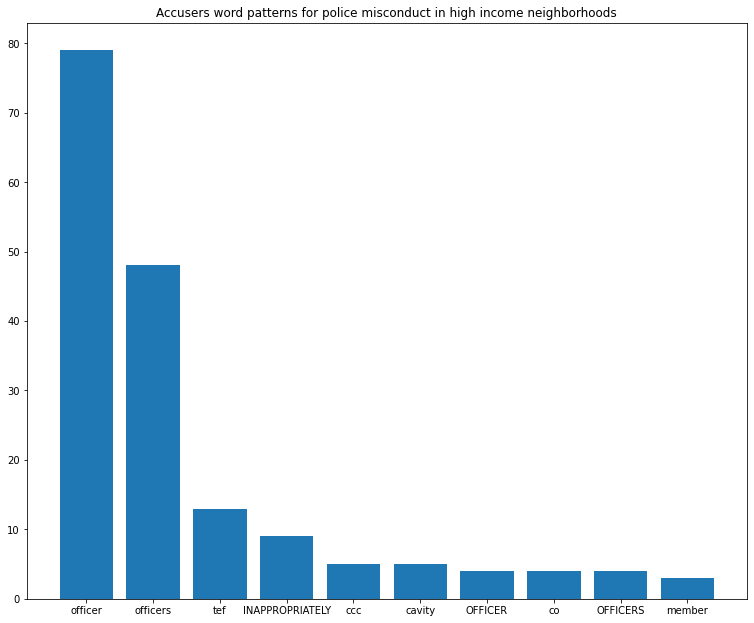

In [ ]:
graph = results['Accusers'][:10] ## limit to 10 to see the most pattern matches
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
words = [word for word, freq in graph]
freqs = [freq for word, freq in graph]
ax.bar(words, freqs)
fig.set_size_inches(10, 8)
plt.title("Accusers word patterns for police misconduct in high income neighborhoods")
plt.show()

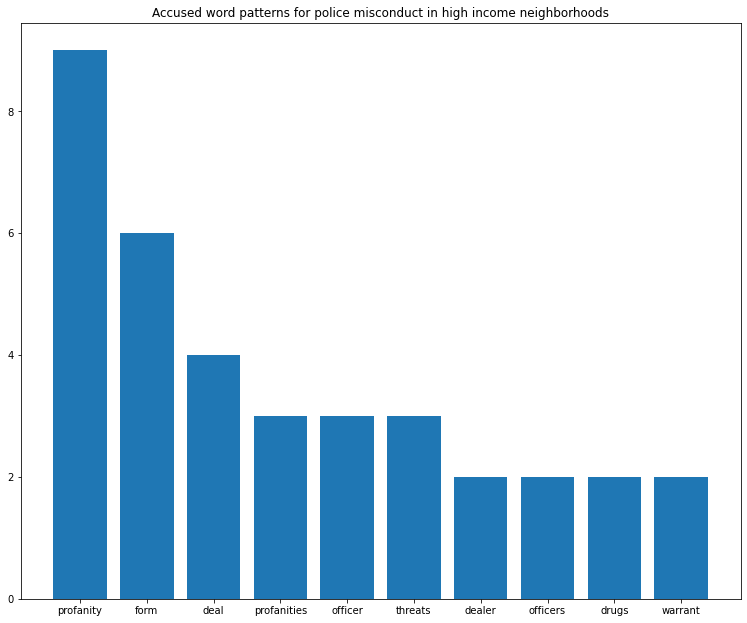

In [ ]:
graph = results['Accused'][:10] ## limit to 10 to see the most pattern matches
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
words = [word for word, freq in graph]
freqs = [freq for word, freq in graph]
ax.bar(words, freqs)
fig.set_size_inches(10, 8)
plt.title("Accused word patterns for police misconduct in high income neighborhoods")
plt.show()

Using spacy tokenization, we are able to see that in low income neighborhoods, the accused police misconduct is linked to primarily illegal activity, followed by drug, and illegal search. In middle income neighborhoods, the accused police misconduct is primarily illegal search, followed by drug. Finally, in the high income neighborhoods, the accused police misconduct is primarily profanities. We see that in high income neighborhoods, the narrative about misconduct is very different than low and middle income neighborhoods. To find out exact what was alleged and what the person is alleging in different income neighborhoods. We want to build NLP transformer to answer this question for us. 

## NLP Transformers 

Overview: The Transformer in NLP is a novel architecture that aims to solve sequence-to-sequence tasks while handling long-range dependencies with ease.


**Question 3: What misconduct was alleged by the accuser? We want to understand what the officer is being accused of and we want to figure out what the socialeconomic status is of the accuser. This will give us insight into if the accuser behaves differently depending on their socialeconomic status.**

In [ ]:
def get_misconduct(row, income_neighborhood): ## limit to answer with confidence score > 0.7
  accuser = list(set(row['accuser']))[0] if row['accuser'] else None
  accused = list(set(row['accused']))[0] if row['accused'] else None
  if not accuser and not accused:
    return ('', 0.0)

  if accuser:
    question = f'What was alleged by the {accuser} in the {income_neighborhood} income neighborhoods?'
  if accused:
    question = f'What was the {accused} accused of in the {income_neighborhood} income neighborhoods?'

  question = {
      'question': question,
      'context': row['text']
  }
  answer = query(question)
  if answer['score'] > 0.7:
    print(question)
    print(f"{answer['answer'], answer['score']}\n")
  return (answer['answer'], answer['score'])

lowIncomeNarratives['allegation'] = lowIncomeNarratives.apply(get_misconduct, axis=1, args=('low',))
middleIncomeNarratives['allegation'] = middleIncomeNarratives.apply(get_misconduct, axis=1, args=('middle',))
highIncomeNarratives['allegation'] = highIncomeNarratives.apply(get_misconduct, axis=1, args=('high',))


{'question': 'What was the activity accused of in the low income neighborhoods?', 'context': 'The reporting party alleges that he called 911 after observing an unknown male subject selling cigarettes to minors, twenty- four hours a day and seven days a week The reporting party alleges that a white male uniformed officer failed to arrest the black male subject, who had left the scene. The reporting party alleges that due to the officer\'s failure to patrol the area in an efficient manner, the male subject got away. The reporting party alleges that he requested the officer\'s star number and the officer refused to provide it. The reporting party alleges that he called 911 and requested a supervisor and a white male uniformed supervisor, with possible star number "897" failed to reprimand the officer for not providing his information. The reporting party states that due to his poor vision, even with eyeglasses that he was unable to provide additional information regarding the officer, sup

## Minimum Confidence Threshold

In [ ]:
min_confidence = 0.7

lowIncomeFiltered = deepcopy(lowIncomeNarratives)

# Filtering by score, removing null results
lowIncomeFiltered['allegation'] = lowIncomeFiltered['allegation'].map(lambda t: ('', 0.0) if t[1] < min_confidence else t) 
lowIncomeFiltered = lowIncomeFiltered[lowIncomeFiltered['allegation'] != ('', 0.0)]

# # Sorting allegation texts by score
lowIncomeFiltered = lowIncomeFiltered.sort_values('allegation', key=lambda series: series.map(lambda a: a[1]))

# First ten entries where confidence > 0.7
for allegation, score in lowIncomeFiltered['allegation'][:20]:
  print(f'{allegation} | SCORE:{score}')

selling snow cones | SCORE:0.7281588912010193
illegal | SCORE:0.8585631847381592
drug | SCORE:0.8815926909446716
heroin | SCORE:0.9636984467506409


In [ ]:
middleIncomeFiltered = deepcopy(middleIncomeNarratives)
# Filtering by score, removing null results
middleIncomeFiltered['allegation'] = middleIncomeFiltered['allegation'].map(lambda t: ('', 0.0) if t[1] < min_confidence else t) 
middleIncomeFiltered = middleIncomeFiltered[middleIncomeFiltered['allegation'] != ('', 0.0)]

# # Sorting allegation texts by score
middleIncomeFiltered = middleIncomeFiltered.sort_values('allegation', key=lambda series: series.map(lambda a: a[1]))

# First ten entries where confidence > 0.7
for allegation, score in middleIncomeFiltered['allegation'][:20]:
  print(f'{allegation} | SCORE:{score}')

control substance | SCORE:0.7602573037147522
drug | SCORE:0.8005700707435608


In [ ]:
highIncomeFiltered = deepcopy(highIncomeNarratives)
highIncomeFiltered
# Filtering by score, removing null results
highIncomeFiltered['allegation'] = highIncomeFiltered['allegation'].map(lambda t: ('', 0.0) if t[1] < min_confidence else t) 
highIncomeFiltered = highIncomeFiltered[highIncomeFiltered['allegation'] != ('', 0.0)]

# # Sorting allegation texts by score
highIncomeFiltered = highIncomeFiltered.sort_values('allegation', key=lambda series: series.map(lambda a: a[1]))

# First ten entries where confidence > 0.7
for allegation, score in highIncomeFiltered['allegation'][:20]:
  print(f'{allegation} | SCORE:{score}')

arrested him without justification | SCORE:0.7070499658584595
drug | SCORE:0.7214781641960144
childhood friends | SCORE:0.7246384620666504
Non-Departmental business | SCORE:0.7302817702293396
searched his vehicle without a warrant or permission | SCORE:0.7483714818954468
drug | SCORE:0.7799287438392639
uncooperative, rude and unprofessional | SCORE:0.7806355953216553
unprofessional | SCORE:0.8041682243347168
narcotics | SCORE:0.8475009202957153
searched him inappropriately | SCORE:0.8567609190940857
excessive force | SCORE:0.9093132615089417


We build this model to help us understand the narratives about police misconduct in different income neighborhoods. We select the question and answer pair that have the confidence > 0.7 to be more accurate. In addition, we see a transition from low to middle to high income neighborhoods in the context of types of misconduct. In low income neighborhoods, drug is the primary reason; in middle income neighborhoods, we see more illegal search; in high income neighborhoods, we see more profanity. The level of severity decreases as you enter different income neighborhoods.

## Sentiment Analysis

Overview: Sentiment Analysis (also known as opinion mining or emotion AI) is a sub-field of NLP that tries to identify and extract opinions within a given text across blogs, reviews, social media, forums, news etc. 

In [117]:
low_income_complaints = pd.read_csv('low_income_allegations.csv')
low_income_complaints.head()
low_income_complaints.shape

(1676, 1)

In [118]:
low_income_complaints_list = low_income_complaints.values.flatten()

# Getting sentiment of all complaints about officer allegations in low income 
# neighborhoods
totalScore = 0
totalNegativeReviews = 0
totalPositiveReviews = 0
totalReviews = 0
for test in low_income_complaints_list: 
  if len(test) > 512:
    continue
  totalReviews += 1
  sTest = sentiment_analyzer(test)
  resultDict = sTest[0]
  totalScore += resultDict['score']
  if resultDict['label'] == 'NEGATIVE':
    totalNegativeReviews += 1
  else:
    totalPositiveReviews += 1
print(f"In low income neighborhoods, we have: ")
print(f"Average Score is {str(totalScore/totalReviews)[:4]}")
print(f"Total Negative Score is {str(totalNegativeReviews/totalReviews)[:4]}%")
print(f"Total Positive Score is {str(totalPositiveReviews/totalReviews)[:4]}%")

In low income neighborhoods, we have: 
Average Score is 0.99
Total Negative Score is 0.99%
Total Positive Score is 0.00%


In [119]:
middle_income_complaints = pd.read_csv('middle_income_allegations.csv')
middle_income_complaints.head()
middle_income_complaints.shape

(2353, 1)

In [120]:
middle_income_complaints_list = middle_income_complaints.values.flatten()

# Getting sentiment of all complaints about officer allegations in middle income 
# neighborhoods
totalScore = 0
totalNegativeReviews = 0
totalPositiveReviews = 0
totalReviews = 0
for test in middle_income_complaints_list: 
  if len(test) > 512:
    continue
  totalReviews += 1
  sTest = sentiment_analyzer(test)
  resultDict = sTest[0]
  totalScore += resultDict['score']
  if resultDict['label'] == 'NEGATIVE':
    totalNegativeReviews += 1
  else:
    totalPositiveReviews += 1
print(f"In middle income neighborhoods, we have: ")
print(f"Average Score is {str(totalScore/totalReviews)[:4]}")
print(f"Total Negative Score is {str(totalNegativeReviews/totalReviews)[:4]}%")
print(f"Total Positive Score is {str(totalPositiveReviews/totalReviews)[:4]}%")

In middle income neighborhoods, we have: 
Average Score is 0.99
Total Negative Score is 0.99%
Total Positive Score is 0.00%


In [121]:
high_income_complaints = pd.read_csv('upper_income_officer_allegations.csv')
high_income_complaints.head()
high_income_complaints.shape

(479, 1)

In [122]:
high_income_complaints_list = high_income_complaints.values.flatten()

# Getting sentiment of all complaints about officer allegations in low income 
# neighborhoods
totalScore = 0
totalNegativeReviews = 0
totalPositiveReviews = 0
totalReviews = 0
for test in high_income_complaints_list: 
  if len(test) > 512:
    continue
  totalReviews += 1
  sTest = sentiment_analyzer(test)
  resultDict = sTest[0]
  totalScore += resultDict['score']
  if resultDict['label'] == 'NEGATIVE':
    totalNegativeReviews += 1
  else:
    totalPositiveReviews += 1
print(f"In high income neighborhoods, we have: ")
print(f"Average Score is {str(totalScore/totalReviews)[:4]}")
print(f"Total Negative Score is {str(totalNegativeReviews/totalReviews)[:4]}")
print(f"Total Positive Score is {str(totalPositiveReviews/totalReviews)[:4]}")

In high income neighborhoods, we have: 
Average Score is 0.99
Total Negative Score is 1.0
Total Positive Score is 0.0


## Normalize the score

**Question 4. what are the top 5 negative complaint narratives for each income neighborhoods?**

In [123]:
import math

def sentiment_score(sentiment):
  sentiment = sentiment_analyzer(sentiment)[0]
  negative = sentiment['label'] == 'NEGATIVE'
  score = math.log(1 - sentiment['score'])
  return round(score, 2) * (1 if negative else -1)

numOfComplaints = 5
for i in range(numOfComplaints): 
  if len(test) > 512:
    continue
  complaint = low_income_complaints_list[i]
  print(f'{complaint[31:]}\nScore : {sentiment_score(complaint)}\n')
  

The reporting party alleges that while sitting
in his mother's parked vehicle several
uniformed and plainclothes officers, one
possibly named "Schmidt", approached him
and stated, "Put your hands up, are you
from around here, what are you doing over
here, there was a shooting and the man
shot described your car, this happened
about two days ago” The reporting party
alleges that the officers handcuffed and
searched him and the vehicle without
Justification The reporting party alleges that
the officers searched the inside of the
vehicle and trunk areas The reporting party
further alleges that the officers damaged the
rear seats and the plastic or polymer
moldings located in the trunk of the vehicle,
duning their search
Initial / Intake Allegation 4: The reporting party alleges that while sitting
in his mother's parked vehicle several
uniformed and plainclothes officers, one
possibly named "Schmidt", approached him
and stated, "Put your hands up, are you
from around here, what are you doi

In [124]:
numOfComplaints = 5
for i in range(numOfComplaints): 
  if len(test) > 512:
    continue
  complaint = middle_income_complaints_list[i]
  print(f'{complaint[31:50]}\nScore : {sentiment_score(complaint)}\n')

It is reported that
Score : -5.35

It is reported that
Score : -5.81

It is reported that
Score : -6.97

CONFIDENTIAL INVEST
Score : -6.28

The reporting party
Score : -6.18



In [125]:
numOfComplaints = 5
for i in range(numOfComplaints): 
  if len(test) > 512:
    continue
  complaint = high_income_complaints_list[i]
  print(f'{complaint[31:]}\nScore : {sentiment_score(complaint)}\n')

The reporting party alleges that three male
white plainclothes officers stopped and
searched him and his personal vehicle for
no apparent reason. The reporting party
alleges that the officers falsely arrested him
for possession of a gun.
Finding 1: (None Entered)

Score : -6.52

The reporting party alleges that three male
white plainclothes officers stopped and
searched him and his personal vehicle for
no apparent reason. The reporting party
alleges that the officers falsely arrested him
for possession of a gun.
Finding 1: (None Entered)

Score : -6.52

The reporting party alleges that three male
white plainclothes officers stopped and
searched him and his personal vehicle for
no apparent reason. The reporting party
alleges that the officers falsely arrested him
for possession of a gun.
Finding 1: (None Entered)

Score : -6.52

The reporting party alleges that during the
traffic stop, the accused screamed and
yelled at him. The reporting party further
alleges that the accused stated If